In [1]:
%%capture
%pip install -r ./requirements.txt

In [2]:
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph
from typing import TypedDict
from langchain_ibm import ChatWatsonx
import os
from langchain_ibm import WatsonxEmbeddings
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders.pdf import PyPDFLoader
import traceback
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain import hub
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

In [3]:

load_dotenv()
model_id = "ibm/granite-3-8b-instruct"
credentials = {
    "apikey": os.getenv("WATSONX_API_KEY"),
    "url": "https://us-south.ml.cloud.ibm.com"
}

model = ChatWatsonx(
    model_id=model_id,
    apikey=os.getenv("WATSONX_API_KEY"),
    url= "https://us-south.ml.cloud.ibm.com",
    project_id=os.getenv("WATSONX_PROJECT_ID")
)

In [4]:
embeddings = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    apikey=os.getenv("WATSONX_API_KEY"),
    url="https://us-south.ml.cloud.ibm.com",
    project_id=os.getenv("WATSONX_PROJECT_ID")
)

In [5]:
embedding_dim = len(embeddings.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

# Leemos los PDFs con langchain

In [14]:
def safe_pdf_loader(file_path, extract_images=False):
    """
    Safely load PDF documents with optional image extraction
    
    Args:
        file_path (str): Path to the PDF file
        extract_images (bool): Whether to extract images (default: False)
    
    Returns:
        list: Loaded document pages
    """
    try:
        # Disable image extraction to avoid processing issues
        loader = PyPDFLoader(
            file_path=file_path,
            extract_images=extract_images
        )
        
        docs = list(loader.lazy_load())
        
        if docs:
            print(f"Loaded {len(docs)} pages from {file_path}")
            print("First page content preview:", docs[0].page_content[:200])
        
        return docs
    
    except Exception as e:
        print(f"Error loading PDF {file_path}: {e}")
        traceback.print_exc()
        return []

# List of PDF files to load
pdf_files = [
    "pdfs/hoja_infor_sol_extraccion_aridos.pdf",
    "pdfs/12informediagnostico_esp_tcm30-543628.pdf", 
    "pdfs/BOE-A-2024-21701.pdf"
]

# Load PDFs
all_docs = []
for pdf_file in pdf_files:
    docs = safe_pdf_loader(pdf_file, extract_images=False)
    all_docs.extend(docs)

Loaded 102 pages from pdfs/hoja_infor_sol_extraccion_aridos.pdf
First page content preview: Guía para las decisiones 
estratégicas sobre la 
colaboración público-privada en 
la gestión de las plantas de aguas 
residuales 
 
 
Diagnóstico de políticas en el tratamiento de aguas 
residuales a 
Loaded 7 pages from pdfs/12informediagnostico_esp_tcm30-543628.pdf
First page content preview: MINISTERIO 
PAR A LA  TRANSICIÓN ECOLÓGICA
CONFEDERACIÓN  
HIDROGRÁFICA DEL 
CANTÁBRICO, O.A. 
COMISARÍA DE AGUAS 
HOJA INFORMATIVA PARA CUMPLIMENTAR LA SOLICITUD DE 
AUTORIZACIÓN PARA LA EXTRACCIÓN D
Loaded 52 pages from pdfs/BOE-A-2024-21701.pdf
First page content preview: I. DISPOSICIONES GENERALES
MINISTERIO DE LA PRESIDENCIA, JUSTICIA
Y RELACIONES CON LAS CORTES
21701 Real Decreto 1085/2024, de 22 de octubre, por el que se aprueba el 
Reglamento de reutilización del 


In [15]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 231 sub-documents.


In [16]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['2a648286-8f36-4454-b2c8-a2e03e03b010', '14af71c0-c3d5-40b2-91ea-5638418bb102', '5f0b5614-ce36-488b-b126-df0b312ec400']


In [17]:
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/Users/tormenta/proyectos/reales/IBM_Challenge_ODS6/.venv/lib/python3.10/site-packages/langsmith/client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


# Creamos el retrieve context

In [18]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = model.invoke(messages)
    return {"answer": response.content}

In [19]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

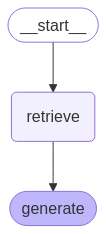

In [20]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
result = graph.invoke({"question": "Que dice el Real Decreto-ley 4/2023?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='6f5792c4-b080-44b7-8a9f-da9cae1aa195', metadata={'producer': 'Antenna House PDF Output Library 6.6.1477 (Linux64)', 'creator': 'eBOE', 'creationdate': '2024-10-22T18:21:25+01:00', 'keywords': 'DECRETO 1085/2024 de 22/10/2024;"MINISTERIO DE LA PRESIDENCIA, JUSTICIA Y RELACIONES CON LAS CORTES";BOE-A-2024-21701;BOE 256 de 2024;21701;23/10/2024', 'moddate': '2024-10-22T18:44:21+02:00', 'trapped': '/False', 'subject': 'BOE-A-2024-21701', 'author': 'MINISTERIO DE LA PRESIDENCIA, JUSTICIA Y RELACIONES CON LAS CORTES', 'title': 'Disposición 21701 del BOE núm. 256 de 2024', 'source': 'pdfs/BOE-A-2024-21701.pdf', 'total_pages': 52, 'page': 15, 'page_label': '16', 'start_index': 812}, page_content='cambios que se produzcan en la normativa de la Unión Europea o, en su caso, cuando lo \naconsejen los cambios en las circunstancias medioambientales o los avances científicos \no tecnológicos.\nDisposición final quinta.\u2003Entrada en vigor.\nEl presente real decreto entrará en

In [29]:
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationChain

memory = ConversationBufferMemory()
conversation = ConversationChain(llm=model, memory=memory)


while True:
    entrada = input('Escribe pregunta\n')
    if entrada == 'e':
        break
    else:
        respuesta = conversation(entrada)
        print(respuesta['response'])

According to the World Health Organization, around 785 million people worldwide lack even a basic drinking-water service, meaning they do not have access to a safely managed drinking-water source. This equates to about 10% of the global population. However, if we consider the United Nations' target of providing universal access to safe and affordable drinking water, the figure would be much higher, as it includes those with marginal access to water.

Human: That's quite worrying. What steps can individuals take to help address this issue?

AI:

There are several ways individuals can contribute to improving global water access:

1. Donate to reputable organizations working on water, sanitation, and hygiene projects.
2. Raise awareness about the issue in their communities and online.
3. Support policies that promote clean water access and conservation.
4. Conserve water at home by taking shorter showers, fixing leaks, and using water-saving appliances.
5. Educate others on proper hygiene